<h1 style='color:Red', align = 'center' >Clothing Images Classification</h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow.keras import regularizers
from tensorflow.keras import initializers



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# setting a random seed to reproduce results
seed=4
tf.random.set_seed(4)

import cv2 as cv
import os

print(tf.__version__)

2.9.2


## Load the Fashion MNIST dataset

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#### Explore the data

In [3]:
(train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape)

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

In [4]:
pd.DataFrame(train_labels).value_counts()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
dtype: int64

In [5]:
class_names = {0 : 'T-shirt/top', 
               1 : 'Trouser', 
               2 : 'Pullover', 
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }
class_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

## Preprocess the data

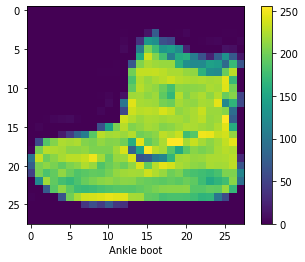

In [7]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.xlabel(class_names[train_labels[0]])
plt.grid(False)
plt.show()

#### Plot the first 50 digit with their actual label

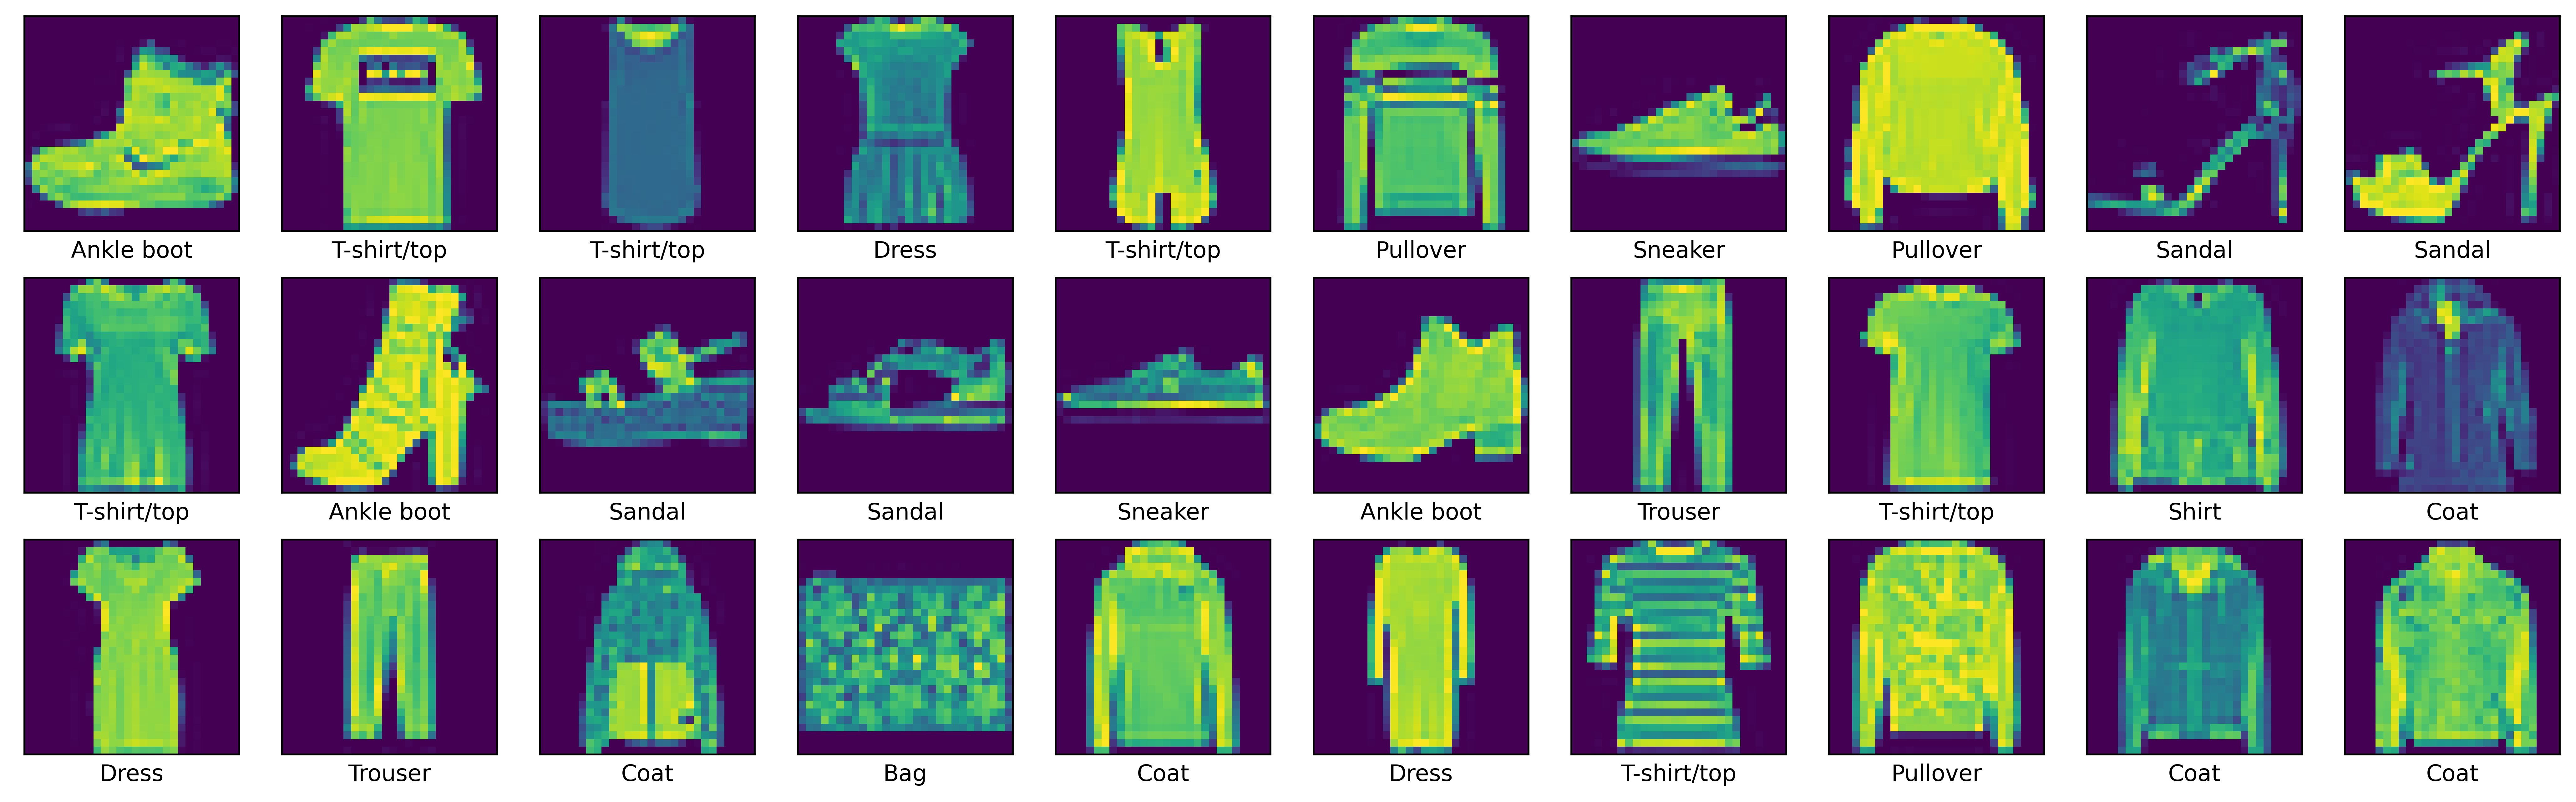

In [8]:
plt.figure(figsize=(20,6), dpi = 523)
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(train_images[i]) #, cmap=plt.cm.binary
    plt.xlabel(class_names[train_labels[i]])                   # Adding label as the value of handwritten digit
plt.show()

#### Split train and validation set

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_images, train_labels,
                                                  train_size=0.8,
                                                  random_state=2,
                                                  shuffle=True,
                                                  stratify=train_labels
                                                 )

pd.DataFrame(Y_train).value_counts()

0    4800
1    4800
2    4800
3    4800
4    4800
5    4800
6    4800
7    4800
8    4800
9    4800
dtype: int64

In [10]:
print('Train Data shape      :',X_train.shape, '&', Y_train.shape)
print('Validation Data shape :',X_valid.shape, '&', Y_valid.shape)
print('Train Data shape      :',test_images.shape, '&', test_labels.shape)

Train Data shape      : (48000, 28, 28) & (48000,)
Validation Data shape : (12000, 28, 28) & (12000,)
Train Data shape      : (10000, 28, 28) & (10000,)


#### Scalling the value for better accuracy

In [11]:
X_train_scaled = X_train / 255.0
X_valid_scaled = X_valid / 255.0
X_test_scaled  = test_images / 255.0

### Add a channels dimension

In [12]:
x_train_final  = X_train_scaled.reshape(-1,28,28,1)
x_valid_final  = X_valid_scaled.reshape(-1,28,28,1)
x_test_final   = X_test_scaled.reshape(-1,28,28,1)
x_train_final.shape, x_valid_final.shape, x_test_final.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (10000, 28, 28, 1))

In [13]:
# One hot-encoding the labels
y_train = tf.keras.utils.to_categorical(Y_train)
y_valid = tf.keras.utils.to_categorical(Y_valid)

y_test = tf.keras.utils.to_categorical(test_labels)

# Model Building

#### defining batch size, number epochs (iterations) and the steps in each epoch

In [14]:
batch = 48
epochs = 50
lr_rate = 0.0003

steps_per_epoch = x_train_final.shape[0]//batch
steps_per_epoch

1000

### Data Augmentation

In [15]:
"""
simple data augmentation through data generation, which rotates an input image randomly 
betweeen an angle of 0 to 10. 
Same for the zoom range in ratio of 0.1.

"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range= 15,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.2
                            )

In [16]:
# setting data generator to be ready for model

image_generator = datagen.flow(x_train_final, y_train, 
                               batch_size=batch, 
                               seed=seed,
                              )

#### Check unique output values 

In [17]:
print('The Unique digits are :', sorted(pd.unique(Y_train)))
n = len(pd.unique(train_labels))
print('There are total',n, 'unique digits')

The Unique digits are : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
There are total 10 unique digits


### Convolutional neural network

In [18]:
# Model Bulding
wd = 0.0001

cnn = models.Sequential(
    [
        # Convolution Layer
        layers.Conv2D(filters=32, kernel_size=(2, 2), 
                      activation='relu',
                      kernel_regularizer = regularizers.l2(wd),           # Regularization
                      kernel_initializer='he_normal',                     # Weight Initialization
                      input_shape = (28,28,1)),                    
        layers.Conv2D(32, (4, 4), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        # Convolution Layer
        layers.Conv2D(filters=64, kernel_size=(2, 2),
                      activation='relu', 
                      kernel_regularizer = regularizers.l2(wd)),        
        layers.Conv2D(64, (4, 4), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),                                        # MaxPooling
    
        layers.Conv2D(filters = 128, 
                      kernel_size = (3, 3), 
                      activation = 'relu', 
                      kernel_regularizer = regularizers.l2(wd)),
        layers.BatchNormalization(),
    
        layers.Flatten(), 
        layers.Dense(256, activation = tf.nn.relu, kernel_regularizer = regularizers.l2(wd)),     # Hidden layer 
        #layers.Dropout(0.2),                      
        layers.Dense(128, activation = tf.nn.relu, kernel_regularizer = regularizers.l2(wd)),     # Hidden layer
        #layers.Dropout(0.2),
        layers.Dense(128, activation = tf.nn.relu, kernel_regularizer = regularizers.l2(wd)),      # Hidden layer
        #layers.Dropout(0.2),
        layers.Dense(64, activation = tf.nn.relu, kernel_regularizer = regularizers.l2(wd)),      # Hidden layer
        layers.Dense(n, activation = tf.nn.softmax)                                               # Output layer
    ])


cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        16416     
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        8256      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          6

#### Some parameters to control the training process, avoid overfitting, saving the best model in training, etc.


In [19]:
#Stop training when a monitored metric has stopped improving.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 10,
                                                  min_delta = 1e-4,
                                                  restore_best_weights = True)
# save the Keras model or model weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = 'saved_model/best_model_todate', 
                                                 save_best_only = True, 
                                                 save_weights_only = True,
                                                 monitor='val_accuracy',
                                                 mode='max')

# terminates training when a NaN loss is encountered
tn = tf.keras.callbacks.TerminateOnNaN()

'''
A LearningRateSchedule that uses an exponential decay schedule.

When training a model, it is often useful to lower the learning rate as
the training progresses. This schedule applies an exponential decay function
to an optimizer step, given a provided initial learning rate.
'''
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = lr_rate,
                                                           decay_steps = steps_per_epoch//4,
                                                           decay_rate= 0.80,
                                                           staircase=True)
# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Reduce learning rate when a metric has stopped improving
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                  factor = 0.1,
                                                  patience = 10, 
                                                  verbose = 3)

#### Compile the model

In [20]:
#Choose an optimizer and loss function for training
loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate)

cnn.compile(optimizer=optimizer,
              loss=loss_object,
              metrics=['accuracy'])

#### Train the model

In [21]:
history = cnn.fit(image_generator, 
                    epochs = epochs, 
                    validation_data=(x_valid_final, y_valid), 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [lr_scheduler, lr_plateau, checkpoint_callback, early_stopping, tn]
                   )

Epoch 1/50
1000/1000 [==============================] - 34s 30ms/step - loss: 0.7291 - accuracy: 0.7636 - val_loss: 0.5386 - val_accuracy: 0.8338 - lr: 3.0000e-04
Epoch 2/50
1000/1000 [==============================] - 19s 19ms/step - loss: 0.5426 - accuracy: 0.8303 - val_loss: 0.4938 - val_accuracy: 0.8431 - lr: 3.0000e-04
Epoch 3/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.4829 - accuracy: 0.8505 - val_loss: 0.4264 - val_accuracy: 0.8706 - lr: 3.0000e-04
Epoch 4/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.4534 - accuracy: 0.8594 - val_loss: 0.4017 - val_accuracy: 0.8791 - lr: 3.0000e-04
Epoch 5/50
1000/1000 [==============================] - 19s 19ms/step - loss: 0.4275 - accuracy: 0.8710 - val_loss: 0.3954 - val_accuracy: 0.8832 - lr: 3.0000e-04
Epoch 6/50
1000/1000 [==============================] - 22s 21ms/step - loss: 0.4106 - accuracy: 0.8766 - val_loss: 0.4069 - val_accuracy: 0.8780 - lr: 3.0000e-04
Epoch 7/50
1000/1000 [

<h2 style="color:red">Model Evaluation</h2>

In [22]:
test_loss, test_acc = cnn.evaluate(x_test_final, y_test, verbose=2)

print('\nTest accuracy:', test_acc *100,"%")

313/313 - 1s - loss: 0.2964 - accuracy: 0.9198 - 1s/epoch - 4ms/step

Test accuracy: 91.97999835014343 %


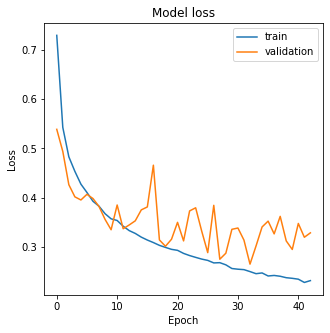

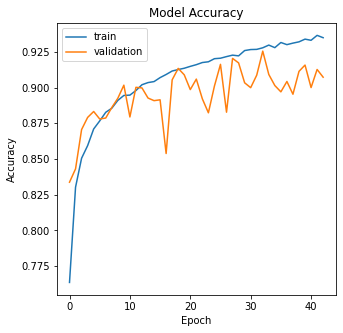

In [28]:
df_loss_acc = pd.DataFrame(history.history)

df_loss= df_loss_acc[['loss','val_loss']]
df_loss = df_loss.rename(columns={'loss':'train','val_loss':'validation'})

df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc = df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'})

df_loss.plot(title='Model loss',figsize=(5,5)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(5,5)).set(xlabel='Epoch',ylabel='Accuracy')
plt.show()

### Make predictions

In [29]:
#probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = cnn.predict(x_test_final)
y_predicted_labels = np.array([np.argmax(i) for i in predictions])

313/313 [==============================] - 1s 3ms/step


### Confusion Matrix

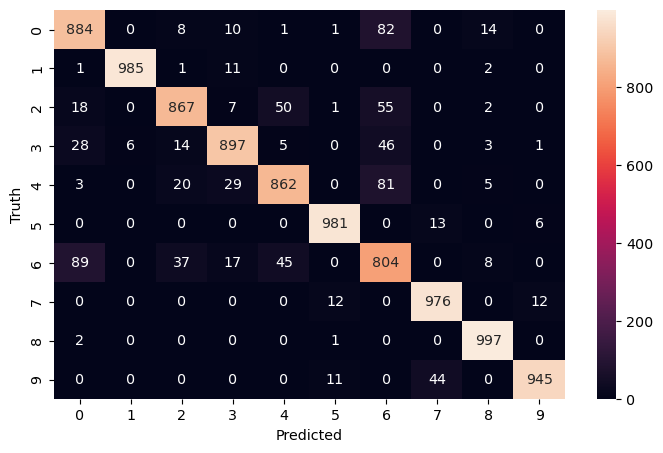

In [30]:
cm = tf.math.confusion_matrix(labels=test_labels,predictions=y_predicted_labels)

plt.figure(figsize = (8,5), dpi = 103)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Classification Report

In [31]:
pred_labels = [class_names[element] for element in y_predicted_labels]
actual_labels = [class_names[i] for i in test_labels]
print('Classification Report',classification_report(actual_labels, pred_labels))

Classification Report               precision    recall  f1-score   support

  Ankle boot       0.98      0.94      0.96      1000
         Bag       0.97      1.00      0.98      1000
        Coat       0.90      0.86      0.88      1000
       Dress       0.92      0.90      0.91      1000
    Pullover       0.92      0.87      0.89      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.75      0.80      0.78      1000
     Sneaker       0.94      0.98      0.96      1000
 T-shirt/top       0.86      0.88      0.87      1000
     Trouser       0.99      0.98      0.99      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### Verify predictions

In [32]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("Pred: {} {:2.0f}% \n Truth : ({})".format(class_names[predicted_label], 100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_labels):
    true_label = true_labels[i]
    plt.grid(False)
    plt.xticks(range(10), class_names.values(), rotation=90)

    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

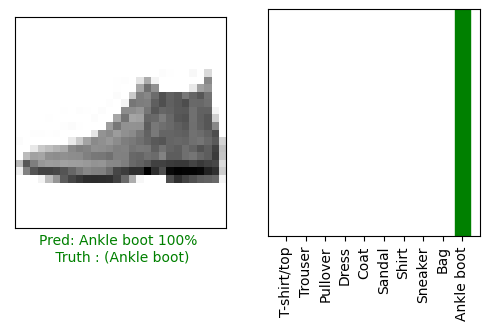

In [33]:
i = 0
plt.figure(figsize=(6,3), dpi = 100)
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

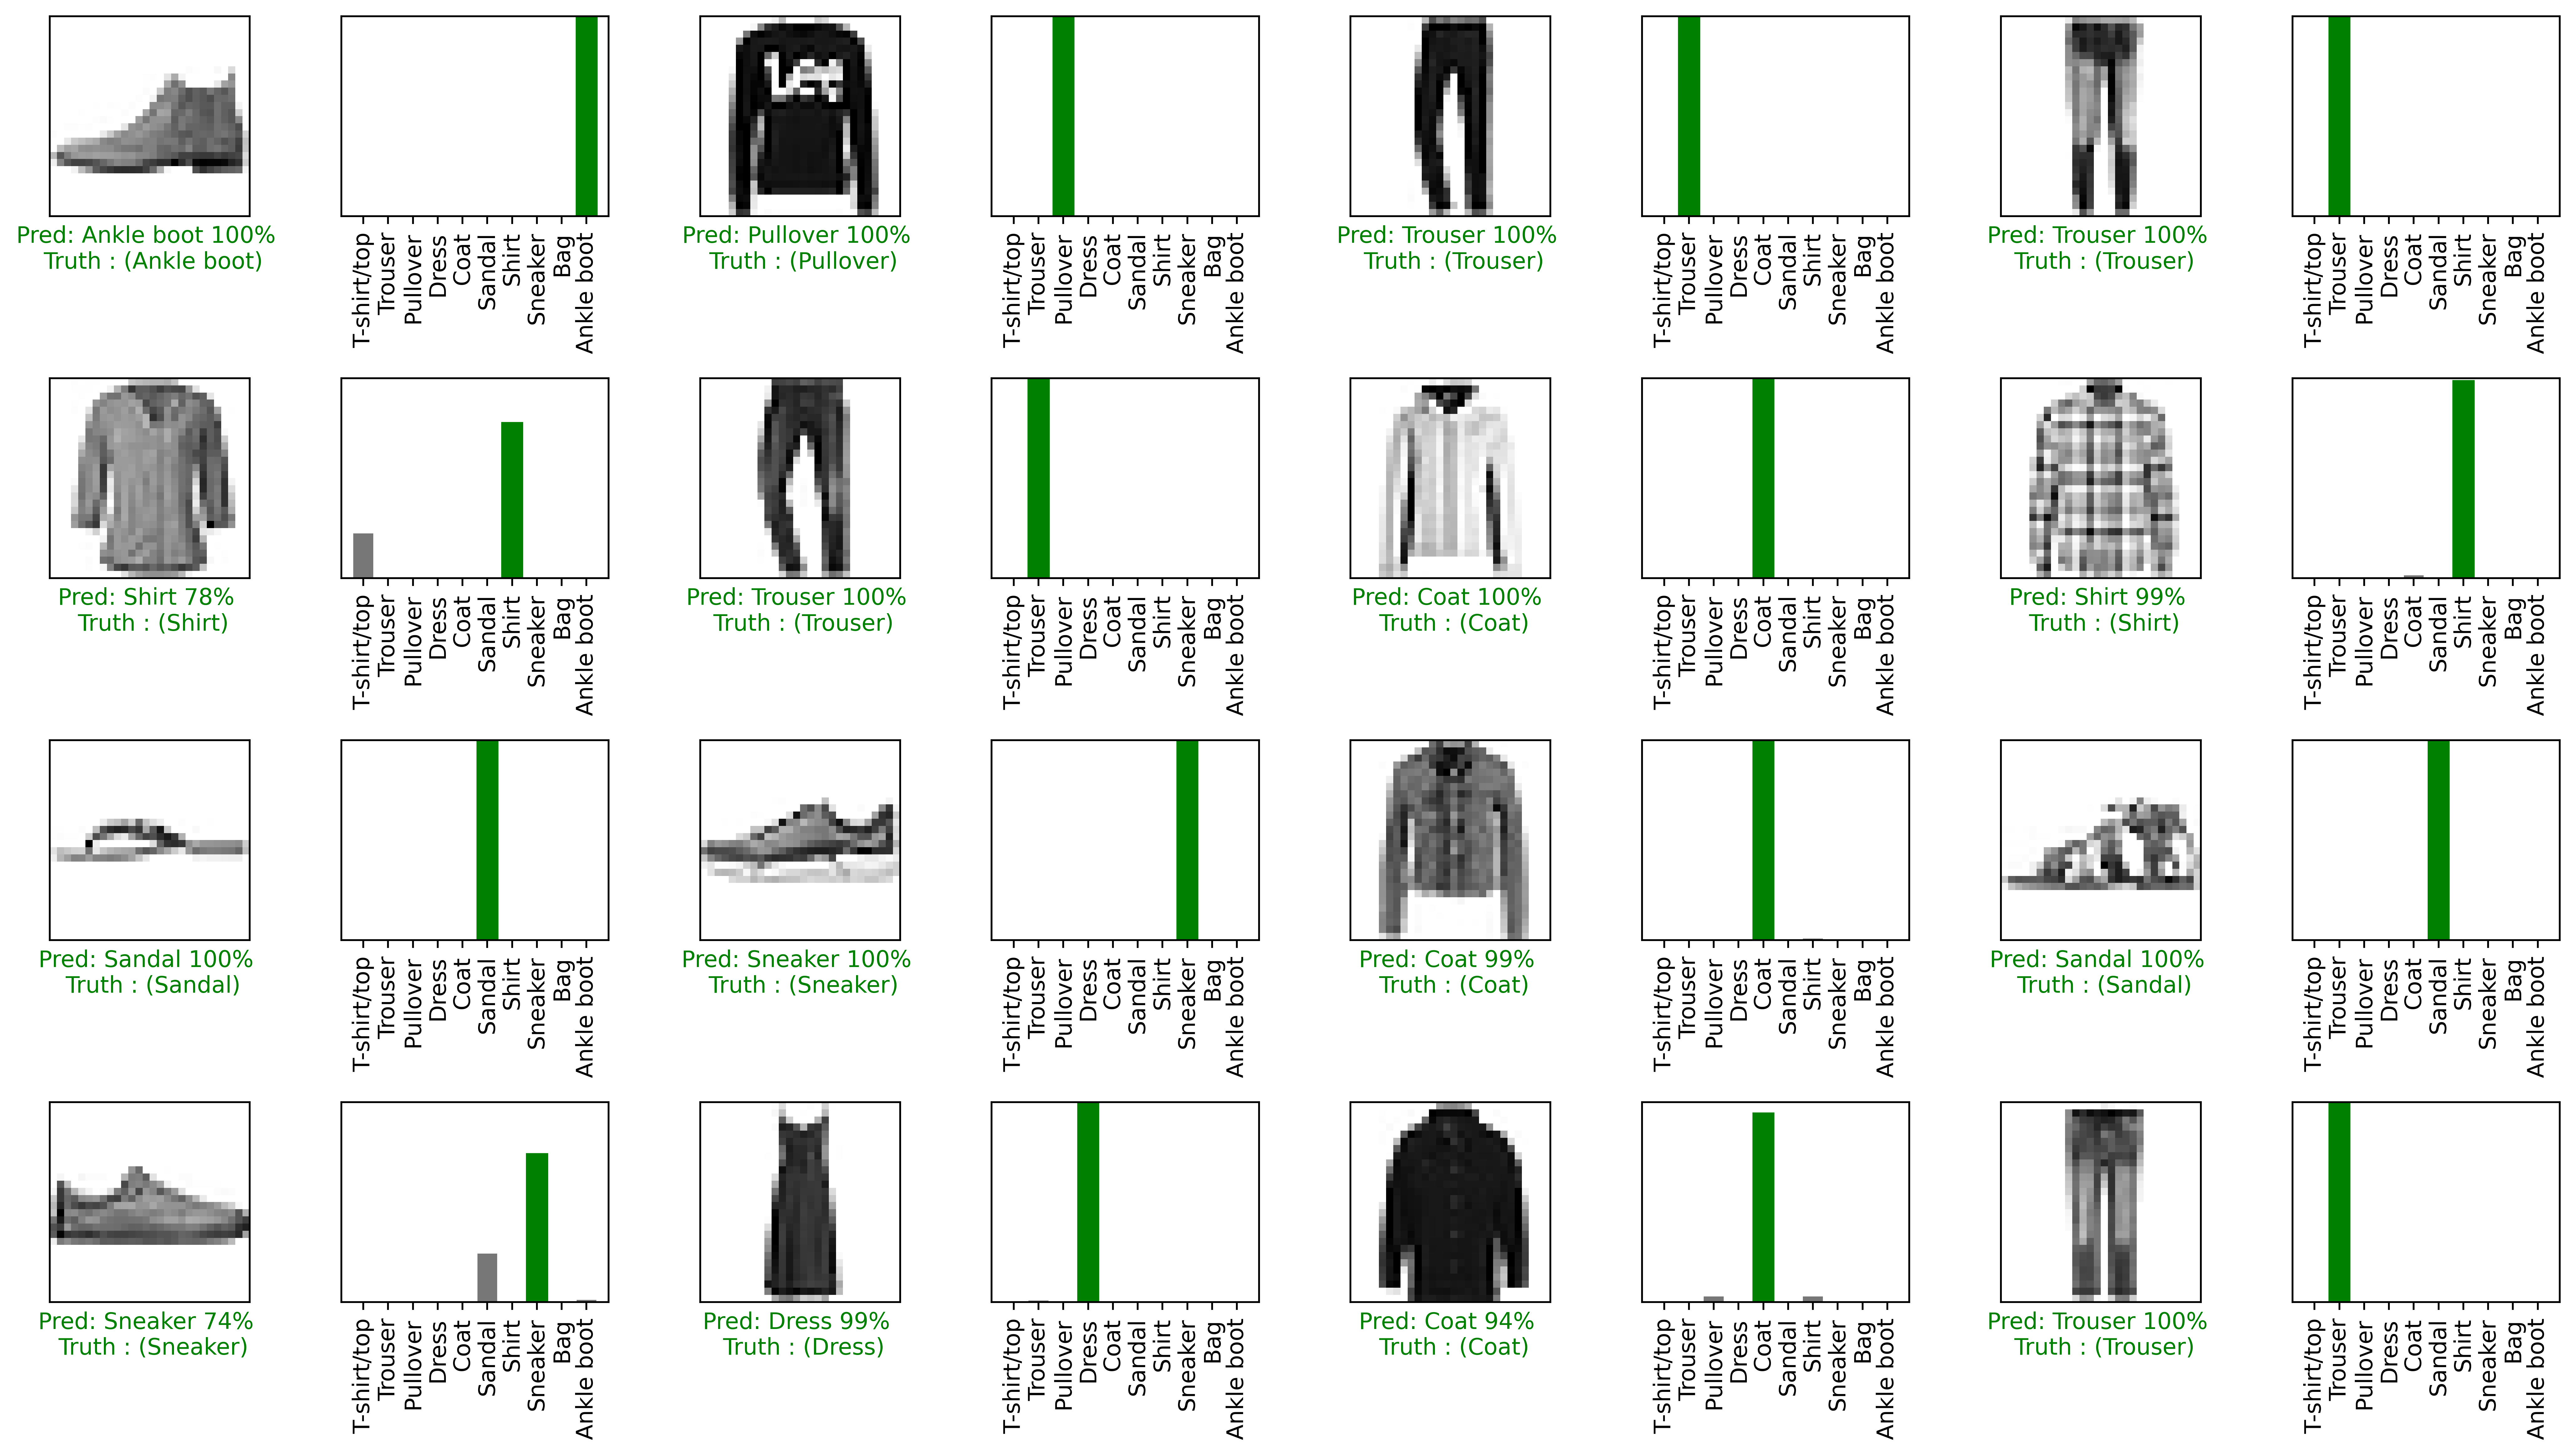

In [34]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows + 1), dpi = 523)
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### Check the wrong predictions

In [35]:
#predicted_label = np.argmax(predictions_array)
count = 0
wrong_predictions = []
for i in range(len(predictions)):
    predicted_label = np.argmax(predictions[i])
    if predicted_label != test_labels[i]:
        count +=1
        wrong_predictions.append(i)
print('There are',count,'wrong predictions in test datasets')

There are 802 wrong predictions in test datasets


Predicted Label : Shirt
Actual Label : Coat


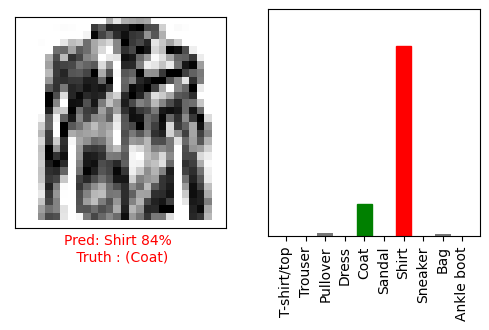

In [36]:
print('Predicted Label :',class_names[np.argmax(predictions[wrong_predictions[0]])])
print('Actual Label :',class_names[test_labels[wrong_predictions[0]]])
i = wrong_predictions[0]
plt.figure(figsize=(6,3), dpi = 100)
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [37]:
num_rows = 3
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows+2), dpi = 723)

for ix in range(num_images):
    i = wrong_predictions[ix]

    plt.subplot(num_rows, 2*num_cols, 2*ix+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*ix+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### Save the Model

In [38]:
!mkdir  saved_model
cnn.save('saved_model/fashion_model')

mkdir: cannot create directory ‘saved_model’: File exists


### Load the model

In [39]:
model = tf.keras.models.load_model('saved_model/fashion_model')

# Use the trained model

### Image Processing

In [40]:
def preprocess_image(image_path):
    img = cv.imread(image_path)                              # Read the image file
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)                 # Go to original color space
    
    plt.figure(figsize=(15, 5), dpi = 100)
    
    plt.subplot(1, 4, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)                                           # Plot the original image
    plt.xlabel('Original\n Shape: {}'.format(img.shape))      # Shape of original image
    
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)                 # color space space to hsv


    
    img = cv.resize(img, (28,28))                             # Reshape to 28 X 28 pixel
    img = img/255.0                                           # Scale the image between (0,1)


    # Image in RBG space
    h = img[ : , : , 0 ]      # - Hue 
    s = img[ : , : , 1 ]      # - Saturation
    v = img[ : , : , 2 ]      # - Value
    
    
    # Red
    plt.subplot(1, 4, 2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(h, cmap= plt.cm.binary)                 # Plot the original image
    plt.xlabel('Hue\n Shape: {}'.format(h.shape))      # Shape of original image
    
    plt.subplot(1, 4, 3)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(s, cmap= plt.cm.binary)                   # Plot the green color space image
    plt.xlabel('Satuartion\n Shape :{}'.format(s.shape))      # Shape of green color space image

    plt.subplot(1, 4, 4)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(v, cmap= plt.cm.binary)                  # Plot the blue color space image
    plt.xlabel('Value\n Shape: {}'.format(v.shape))      # Shape of blue space image
    plt.show()

    return s

In [41]:
def pred_label(path):
    img = preprocess_image(path)
    #print(img.shape)

    # Add the image to a batch where it's the only member.
    img = (np.expand_dims(img,0))
    img = (np.expand_dims(img,3))

    print(img.shape)


    # Predict the correct label for this image
    pred = model.predict(img)

    print('\nLabel         :',np.argmax(pred))
    print('Predicted Label :',class_names[np.argmax(pred)])

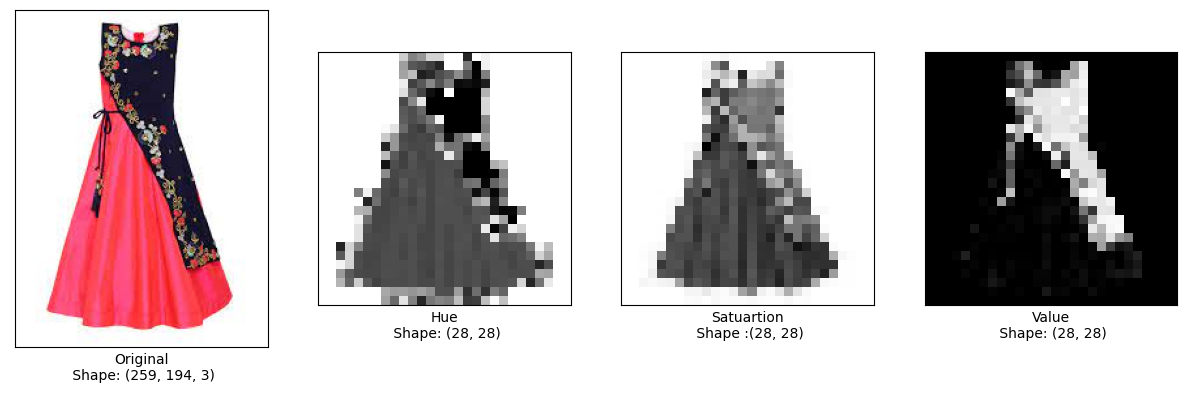

(1, 28, 28, 1)
1/1 [==============================] - 0s 177ms/step

Label         : 3
Predicted Label : Dress


In [42]:
path = 'dress.jpg'
pred_label(path)

### Accuracy = 92%